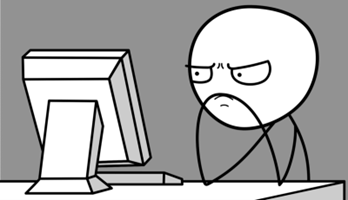

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import bootcampviztools as bt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import cv2
from cv2 import imread
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# deep learning
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential # De aquí sacamos el tipo de modelo que vamos a construir, que sigue siendo una secuencia o cadena de capas consecutivas
from keras.layers import Conv2D # Esta es la capa para convolucionales con entrada de 2 dimensiones
from keras.layers import MaxPool2D # Esta es la clase que corresponde a las capas de Pooling que hacen maxpooling sobre datos de entrada en 2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [2]:
# Cargar datos
train_path = './data/apples/Train'
test_path = './data/apples/Test'

def read_data(root_path, reshape_dim = (32,32)):
    X = []
    y = []

    if not os.path.isdir(root_path):
        print(f"El directorio {root_path} no existe")
        return np.array(X),np.array(y)
    
    # Obtener la lista de carpetas dentro del director raiz
    train_folders = [folder for folder in os.listdir(root_path) if os.path.isdir(os.path.join(root_path,folder))] # obtener la lista de carpetas en el directorio raiz

    for folder in train_folders: # iterar sobre las carpetas de entrenamiento
        folder_path = os.path.join(root_path, folder) # construir la ruta completa
        label = folder # Usar el nombre de la carpeta como etiqueta

        for file in os.listdir(folder_path): # iterar sobre los archivos en la carpeta
            file_path = os.path.join(folder_path, file) # construir la ruta completa a cada imagen
            image = imread(file_path) # leer la imagen
            image = cv2.resize(image, reshape_dim) # redimensionar a 32x32

            X.append(image) # añadir la imagen a la lista de imagenes
            y.append(label) # añadir la etiqueta a la lista de etiquetas
        
    return np.array(X),np.array(y)

In [3]:
X_train, y_train = read_data(train_path)

In [4]:
X_test, y_test = read_data(test_path)

In [5]:
X_test_224, y_test_224 = read_data(test_path, (224,224))

**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

In [6]:
X_train.shape

(6404, 32, 32, 3)

In [7]:
np.unique(y_train)

array(['Braeburn', 'CrimsonSnow', 'Golden1', 'Golden2', 'Golden3',
       'GrannySmith', 'PinkLady', 'Red1', 'Red2', 'Red3', 'RedDelicious',
       'RedYellow1', 'RedYellow2'], dtype='<U12')

In [8]:
def visualize_images(X, y, num_images=10):
    if len(X) == 0:
        print("No hay imágenes para mostrar.")
        return
    
    num_images = min(num_images, len(X))  # Asegurar que no se exceda el número de imágenes disponibles
    indices = np.random.choice(len(X), num_images, replace=False)  # Seleccionar imágenes aleatorias
    
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB para visualización correcta
        plt.title(y[idx])
        plt.axis('off')
    plt.show()

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

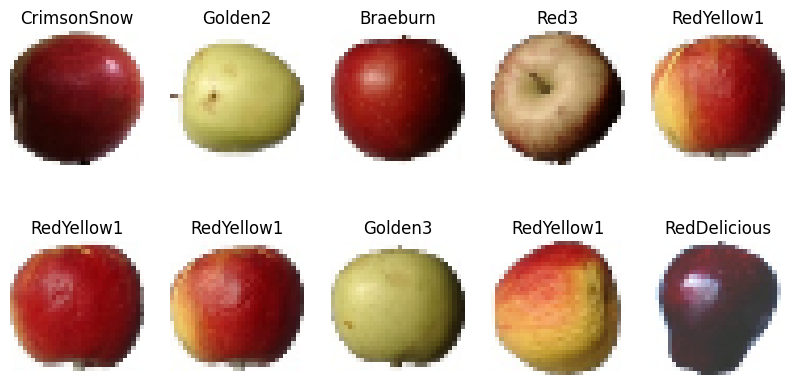

In [9]:
visualize_images(X_train,y_train,10)

In [10]:
pd.DataFrame(y_train).value_counts().sort_index() # revisar las clases en el conjunto de entrenamiento

0           
Braeburn        492
CrimsonSnow     444
Golden1         480
Golden2         492
Golden3         481
GrannySmith     492
PinkLady        456
Red1            492
Red2            492
Red3            429
RedDelicious    490
RedYellow1      492
RedYellow2      672
Name: count, dtype: int64

In [11]:
y_train_df = pd.DataFrame(y_train).rename(columns={0:'apple_class'})

In [12]:
y_train_df

,apple_class
0,Braeburn
1,Braeburn
2,Braeburn
3,Braeburn
4,Braeburn
...,...
6399,RedYellow2
6400,RedYellow2
6401,RedYellow2
6402,RedYellow2


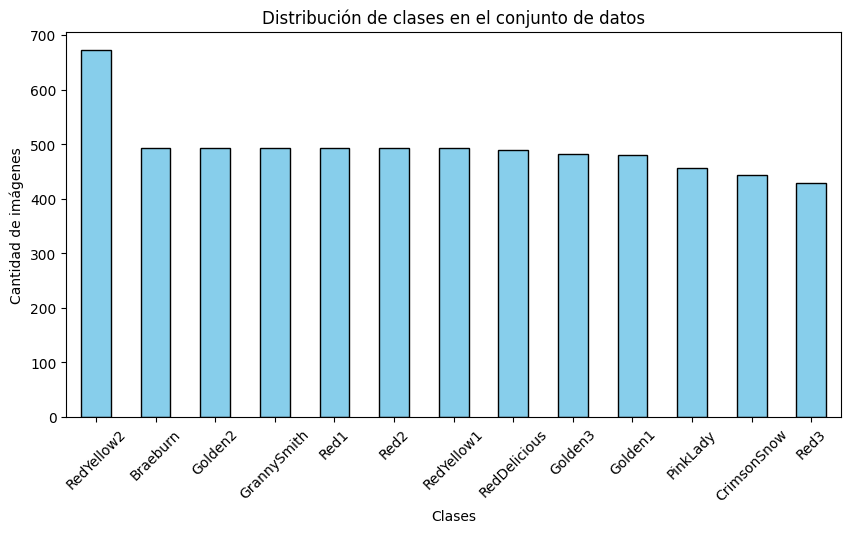

In [13]:
class_counts = y_train_df['apple_class'].value_counts()

plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de clases en el conjunto de datos")
plt.xticks(rotation=45)
plt.show()

In [49]:
np.isnan(X_train).any() # Comprobar si hay valores nulos en el conjunto de entrenamiento


False

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [14]:
# normalización de las imágenes
X_train = X_train / 255.0   # normalizamos los valores de los píxeles entre 0 y 1
X_test = X_test / 255.0

In [15]:
from sklearn.utils import shuffle
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train, random_state=42)

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [16]:
# transformar y_train e y_test a enteros con LabelEncoder
le = LabelEncoder()
y_train_shuffle = le.fit_transform(y_train_shuffle)
y_test = le.transform(y_test)

In [17]:
np.unique(y_train_shuffle)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [18]:
labels_dict = {0: 'Braeburn', 1: 'CrimsonSnow', 2:'Golden1', 3:'Golden2', 4:'Golden3', 5: 'GrannySmith', 6:'PinkLady', 7:'Red1', 8:'Red2', 9: 'Red3', 10: 'RedDelicious', 11: 'RedYellow1', 12:'RedYellow2'}

inverse_labels_dict = {v: k for k, v in labels_dict.items()}


### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [19]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

In [20]:
base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

In [21]:
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [22]:
import random

# seleccionar imagen de forma alatoria
num_samples = 10
indices = random.sample(range(len(X_test_224)),num_samples)
X_test_sample = X_test_224[indices]
y_test_sample = y_test_224[indices]

# Procesar las imagenes tal y como entran en el modelo
x_test_224_preprocess = preprocess_input(X_test_sample)

# predecir
preds = base_model.predict(x_test_224_preprocess)

# decodificar las predicciones
decoded_preds = decode_predictions(preds,top=3)

# Mostrar los resultados

for i, pred in enumerate(decoded_preds):
    print(f"Imagen {i+1} - Etiqueta real: {y_test_sample[i]}")
    for class_id, class_name, score in pred:
        print(f"{class_name}: {score:.4f}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Imagen 1 - Etiqueta real: Red2
Granny_Smith: 0.9995
banana: 0.0002
orange: 0.0001

Imagen 2 - Etiqueta real: GrannySmith
Granny_Smith: 0.5530
croquet_ball: 0.3726
football_helmet: 0.0291

Imagen 3 - Etiqueta real: Red2
Granny_Smith: 0.4955
croquet_ball: 0.4799
peacock: 0.0038

Imagen 4 - Etiqueta real: Red3
croquet_ball: 0.9961
matchstick: 0.0011
maraca: 0.0004

Imagen 5 - Etiqueta real: CrimsonSnow
Granny_Smith: 0.7834
croquet_ball: 0.1098
banana: 0.0155

Imagen 6 - Etiqueta real: RedDelicious
croquet_ball: 0.2014
hair_slide: 0.1419
maraca: 0.1181

Imagen 7 - Etiqueta real: Braeburn
Granny_Smith: 0.9453
croquet_ball: 0.0438
fig: 0.0050

Imagen 8 - Etiqueta real: RedYellow2
balloon: 0.9237
bell_pepper: 0.0477
punching_bag: 0.0076

Imagen 9 - Etiqueta real: PinkLady
Granny_Smith: 0.9962
croquet_ball: 0.0023
punching_bag: 0.0002

Imagen 10 - Etiqueta real: RedYellow2
Granny_Smith: 0.4220
hip: 0.2737
croquet_ball: 0.1988



## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [23]:
base_model = ResNet50V2(input_shape=(32, 32,3),
                        include_top=False, # no consideramos las capas densas
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

# congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False   

# crear la cabeza con dos capas densas

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 300 hidden units and ReLU activation
x = layers.Dense(300, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(13, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])


In [75]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 53,674,613 (204.75 MB)

 Trainable params: 30,109,813 (114.86 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [82]:
X_train_shuffle.shape

(6404, 32, 32, 3)

In [83]:
y_train_shuffle.shape

(6404,)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [87]:
# Entrenar
history = model.fit(X_train_shuffle,y_train_shuffle,
                    validation_split = 0.2,
                    steps_per_epoch = 100, # Cantidad de batches en los que divide el epoch
                    epochs = 10)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - acc: 0.5017 - loss: 1.9515 - val_acc: 0.9352 - val_loss: 0.2506
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - acc: 0.9014 - loss: 0.3372 - val_acc: 0.9813 - val_loss: 0.0937
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - acc: 0.9537 - loss: 0.1579 - val_acc: 0.9961 - val_loss: 0.0428
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - acc: 0.9772 - loss: 0.0973 - val_acc: 0.9984 - val_loss: 0.0312
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - acc: 0.9787 - loss: 0.0781 - val_acc: 0.9977 - val_loss: 0.0232
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - acc: 0.9864 - loss: 0.0557 - val_acc: 0.9977 - val_loss: 0.0133
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - acc: 0.9938 - loss: 0.0385 - val_acc: 0.9984 - val_loss: 0.0104
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - acc: 0.9900 - loss: 0.0363 - val_acc: 0.9992 - val_loss: 0.0065
Epoch 9/10
100/100 ━━━━━━━━━━━━━

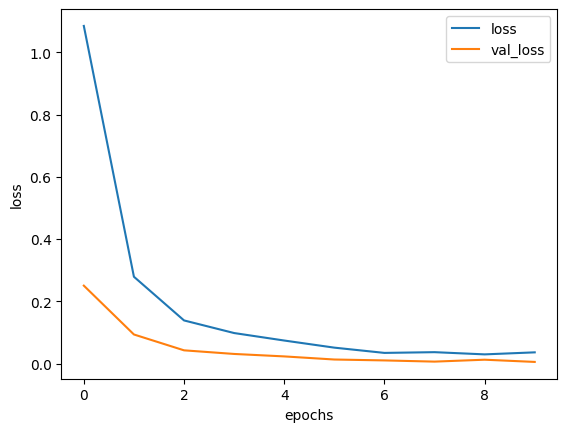

In [88]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

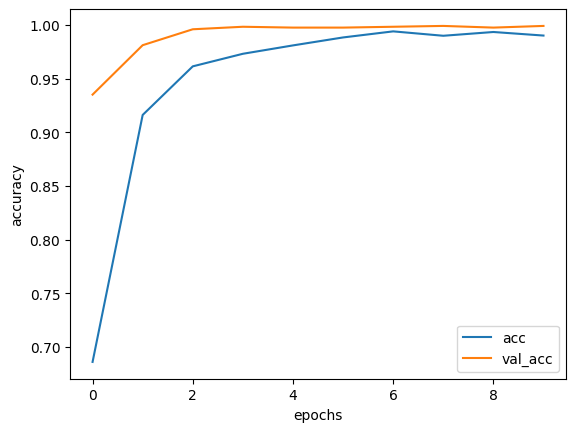

In [90]:
history_df = pd.DataFrame(history.history)
history_df[["acc","val_acc"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

In [91]:
model.evaluate(X_test,y_test)

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - acc: 0.8476 - loss: 0.4399


[0.5084860920906067, 0.836457371711731]

In [92]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]


67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step


In [93]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.81      0.68       164
           1       0.96      0.92      0.94       148
           2       0.75      0.99      0.85       160
           3       1.00      0.81      0.90       164
           4       0.61      0.65      0.63       161
           5       0.95      0.86      0.90       164
           6       0.85      0.79      0.82       152
           7       1.00      0.69      0.82       164
           8       0.58      0.72      0.64       164
           9       0.98      0.65      0.78       144
          10       1.00      1.00      1.00       166
          11       0.92      0.96      0.94       164
          12       0.99      0.97      0.98       219

    accuracy                           0.84      2134
   macro avg       0.86      0.83      0.84      2134
weighted avg       0.86      0.84      0.84      2134



<Figure size 2000x4000 with 0 Axes>

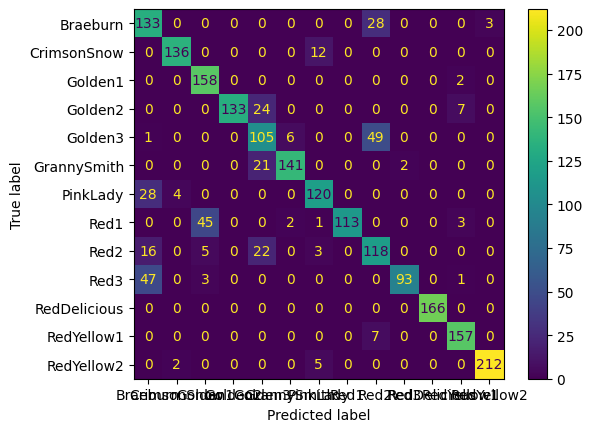

In [98]:
fig = plt.figure(figsize=(20,40))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=list(labels_dict.values()))
plt.show()

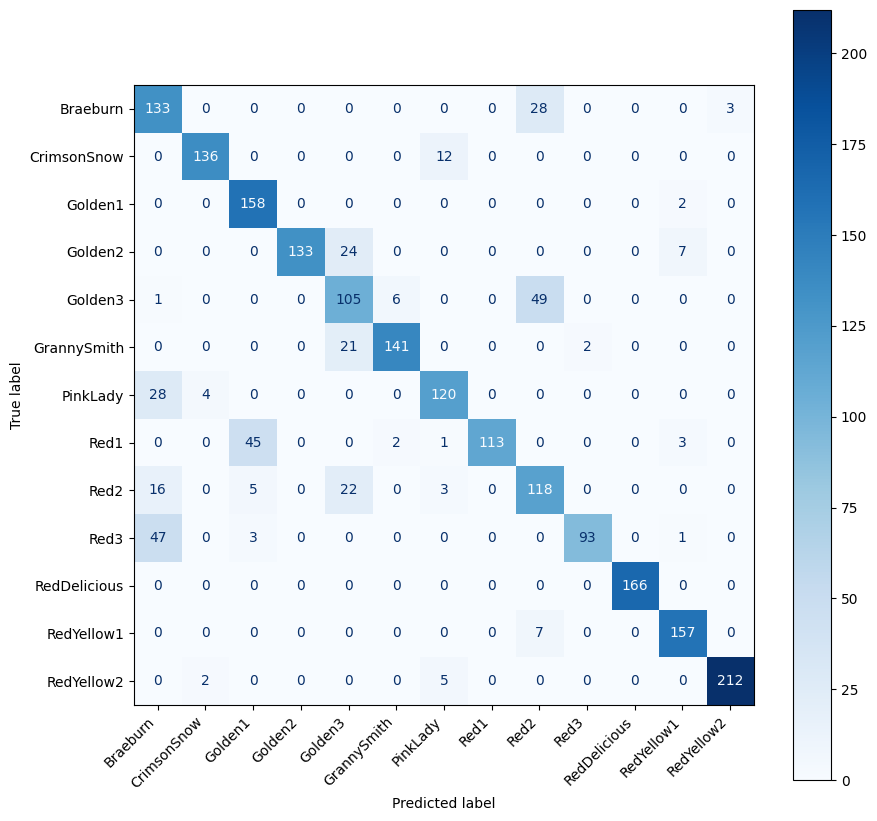

In [106]:
from sklearn.metrics import confusion_matrix
# Mostrar matriz de confusión con etiquetas reales
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels_dict.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()


## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [122]:
base_model = ResNet50V2(input_shape=(32, 32,3),
                        include_top=False, # no consideramos las capas densas
                        weights=None) # Se carga con los pesos entrenados para el dataset de imagenet

# crear la cabeza con dos capas densas

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 300 hidden units and ReLU activation
x = layers.Dense(300, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(13, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

In [108]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 25,420,641 (96.97 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 1,237,228 (4.72 MB)

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [123]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_shuffle, y_train_shuffle, test_size=0.2, stratify=y_train_shuffle,random_state=42)

history = model.fit(X_train_shuffle,y_train_shuffle,
                    validation_data=(X_val, y_val), steps_per_epoch = 64, epochs = 60) # PAra reducir los tiempos de entrenamiento solo haremos epocas de 100 batches, de 20 datos o sea entrenamos con 2000 imagenes por época

Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 616ms/step - acc: 0.6677 - loss: 1.1014 - val_acc: 0.0765 - val_loss: 3.8926
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0765 - val_loss: 3.8926
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 670ms/step - acc: 0.9741 - loss: 0.0942 - val_acc: 0.0765 - val_loss: 7.1794
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0765 - val_loss: 7.1794
Epoch 5/60
16/64 ━━━━━━━━━━━━━━━━━━━━ 31s 653ms/step - acc: 0.9725 - loss: 0.1491

KeyboardInterrupt: 

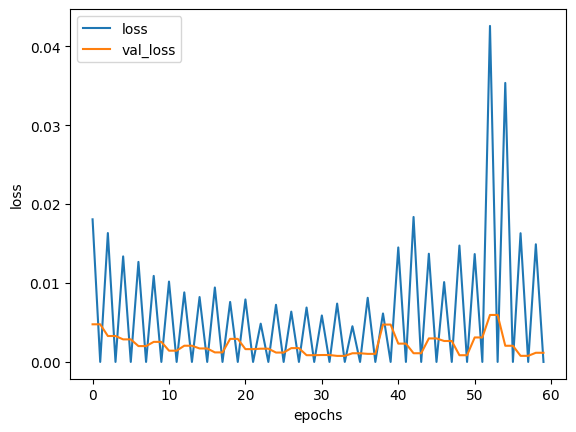

In [110]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

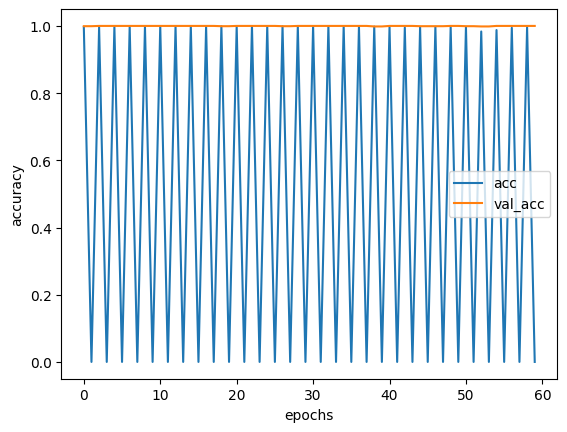

In [115]:
history_df = pd.DataFrame(history.history)
history_df[["acc","val_acc"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [111]:
model.evaluate(X_test,y_test)

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.8857 - loss: 0.4812


[0.6100113987922668, 0.8692595958709717]

In [112]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step


In [113]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.88      0.73       164
           1       0.98      0.89      0.93       148
           2       0.77      1.00      0.87       160
           3       0.99      1.00      1.00       164
           4       0.76      0.63      0.69       161
           5       0.98      0.85      0.91       164
           6       0.84      0.91      0.88       152
           7       1.00      0.77      0.87       164
           8       0.63      0.73      0.68       164
           9       0.94      0.65      0.77       144
          10       1.00      1.00      1.00       166
          11       0.98      0.96      0.97       164
          12       1.00      0.98      0.99       219

    accuracy                           0.87      2134
   macro avg       0.88      0.86      0.87      2134
weighted avg       0.89      0.87      0.87      2134



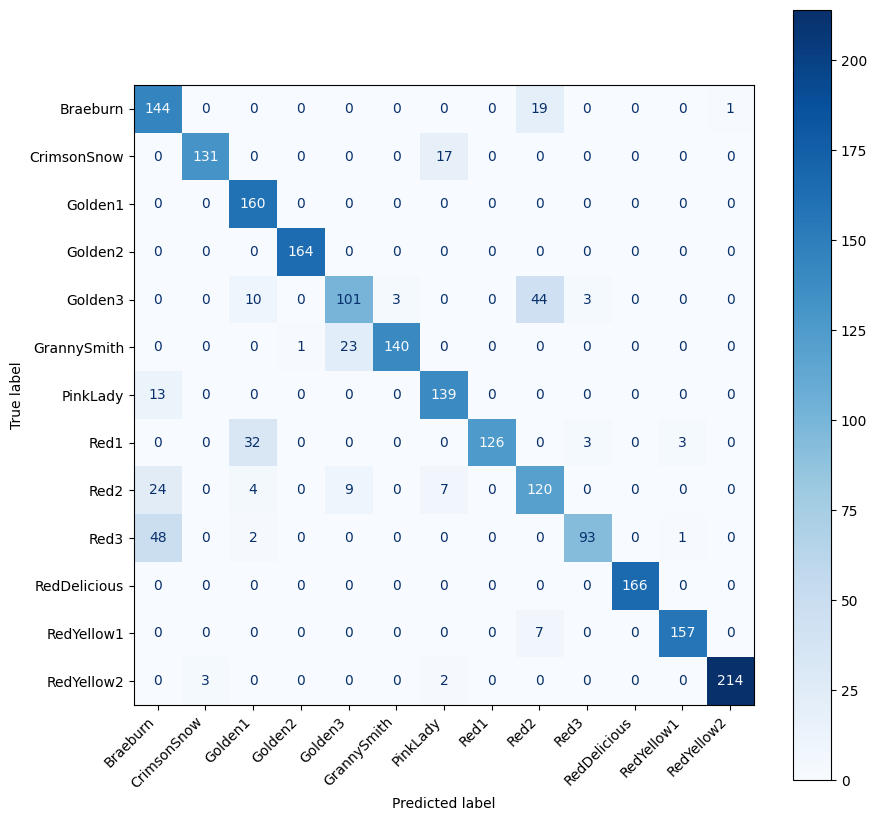

In [114]:
from sklearn.metrics import confusion_matrix
# Mostrar matriz de confusión con etiquetas reales
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels_dict.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()